In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from operator import add
import os
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.ticker import FixedLocator
import matplotlib.font_manager


sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.8, rc=paper_rc)
current_palette = sns.color_palette()
cmp = sns.color_palette("tab10")

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 4),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=14,
        )
    
def autolabel_h(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(
            "%.2f" % width,
            xy=(width, rect.get_y() + rect.get_height() / 2),
            xytext=(18, -1),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="center",
            size=13,
        )

SAVEPATH = './figs'
os.makedirs(SAVEPATH, exist_ok=True)

# DCGM data process

In [2]:
log = pd.read_csv('/home/mzhang/work/TiGraph/dcgmi_logs/new/first_small_gpu3_then_pp4.log', sep='\s\s+', engine='python')
log.to_csv('/home/mzhang/work/TiGraph/dcgmi_logs/test.csv', index=None, mode='w')
df = pd.read_csv('/home/mzhang/work/TiGraph/dcgmi_logs/test.csv')
# df.dropna(axis=0, how='any', inplace=True)  
df = df[df['#Entity'] == 'GPU 3']
df

,#Entity,SMACT,SMOCC,GPUTL,MCUTL,DRAMA,NVLTX,NVLRX,PCITX,PCIRX
1,GPU 3,NaN,NaN,89,21,NaN,NaN,NaN,NaN,NaN
5,GPU 3,NaN,NaN,89,21,NaN,NaN,NaN,NaN,NaN
9,GPU 3,0.610,0.353,89,21,0.166,0,0,12258838,93133842
13,GPU 3,NaN,NaN,81,21,NaN,NaN,NaN,NaN,NaN
17,GPU 3,0.714,0.391,81,21,0.162,0,0,15367022,113946057
...,...,...,...,...,...,...,...,...,...,...
8737,GPU 3,0.783,0.443,100,27,0.215,NaN,36436,6693939,25203775
8741,GPU 3,NaN,NaN,100,27,NaN,0,NaN,NaN,NaN
8745,GPU 3,0.776,0.433,100,28,0.214,NaN,0,5719374,23506627
8749,GPU 3,NaN,NaN,100,28,NaN,0,NaN,NaN,NaN


In [3]:
# Transfer all data to numeric
cols = df.columns.drop('#Entity')
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# For rows where GPUTL != 0 and SMACT is NaN, fill SMACT with the previous valid value
mask = (df['GPUTL'] != 0) & (df['SMACT'].isna())
df.loc[mask, 'SMACT'] = df['SMACT'].ffill()[mask]

# Drop only rows where SMACT is still NaN
df = df.dropna(subset=['SMACT'])

df

,#Entity,SMACT,SMOCC,GPUTL,MCUTL,DRAMA,NVLTX,NVLRX,PCITX,PCIRX
9,GPU 3,0.610,0.353,89,21,0.166,0.0,0.0,12258838.0,93133842.0
13,GPU 3,0.610,NaN,81,21,NaN,NaN,NaN,NaN,NaN
17,GPU 3,0.714,0.391,81,21,0.162,0.0,0.0,15367022.0,113946057.0
21,GPU 3,0.714,0.391,81,21,0.162,0.0,0.0,15367022.0,NaN
25,GPU 3,0.714,NaN,81,21,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8737,GPU 3,0.783,0.443,100,27,0.215,NaN,36436.0,6693939.0,25203775.0
8741,GPU 3,0.783,NaN,100,27,NaN,0.0,NaN,NaN,NaN
8745,GPU 3,0.776,0.433,100,28,0.214,NaN,0.0,5719374.0,23506627.0
8749,GPU 3,0.776,NaN,100,28,NaN,0.0,NaN,NaN,NaN


In [4]:
file_csv = '/home/mzhang/work/TiGraph/dcgmi_logs/new/revgcn_small1_pp4_gpu3_util.csv'
# if os.path.exists(file_csv):
df.to_csv(file_csv, mode='w')

In [5]:
df.index

Index([  12,   16,   20,   24,   28,   32,   36,   40,   44,   48,
       ...
       5874, 5878, 5882, 5886, 5890, 5894, 5898, 5902, 5906, 5910],
      dtype='int64', length=1357)

# RevGCN

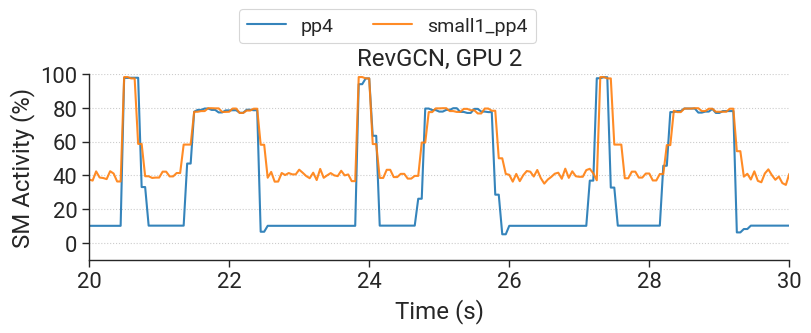

In [45]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_pp4_gpu2_util.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_small1_pp4_gpu2_util.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values *50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values - 639) *50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
# pp4_smact = np.where(pp4_smact > 90, 82, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
# small1_pp4_smact = np.where(small1_pp4_smact > 90, 82, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

# Generate mask for values less than 30
mask = small1_pp4_smact < 30

# Generate random values with mean 40 and standard deviation 3
random_values = np.random.normal(40, 2, size=np.sum(mask))

# Apply the random values where the mask is True
small1_pp4_smact[mask] = random_values

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(20, 30)

# ax1.set_xticks(np.arange(2,22,1))
ax1.grid(axis="y", linestyle=":")
ax1.set_title('RevGCN, GPU 2')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.4), fontsize=14, frameon=True)
save = False
if save:
    fig.savefig(f"./figures/util_trace.pdf", bbox_inches="tight")

In [17]:
df_small1_pp4_gpu0

,Unnamed: 0,#Entity,SMACT,SMOCC,GPUTL,MCUTL,DRAMA,NVLTX,NVLRX,PCITX,PCIRX
0,10,GPU 2,0.741,0.411,93,22,0.180,0.0,0.0,16326822.0,121402440.0
1,14,GPU 2,0.741,NaN,93,22,NaN,NaN,NaN,NaN,NaN
2,18,GPU 2,0.762,0.438,92,24,0.185,0.0,0.0,18439783.0,158493711.0
3,22,GPU 2,0.762,NaN,92,24,NaN,NaN,NaN,NaN,NaN
4,26,GPU 2,0.762,0.419,92,24,0.170,0.0,0.0,15711243.0,116730685.0
...,...,...,...,...,...,...,...,...,...,...,...
2336,9840,GPU 2,0.102,NaN,100,0,NaN,NaN,NaN,NaN,NaN
2337,9844,GPU 2,0.913,0.532,100,0,0.225,20799.0,770495886.0,9047590.0,30189832.0
2338,9848,GPU 2,0.913,NaN,100,31,NaN,NaN,NaN,NaN,NaN
2339,9852,GPU 2,0.972,0.568,100,31,0.243,771096494.0,771106902.0,8024232.0,28501116.0


# RevGCN small1 then pp4, GPU0

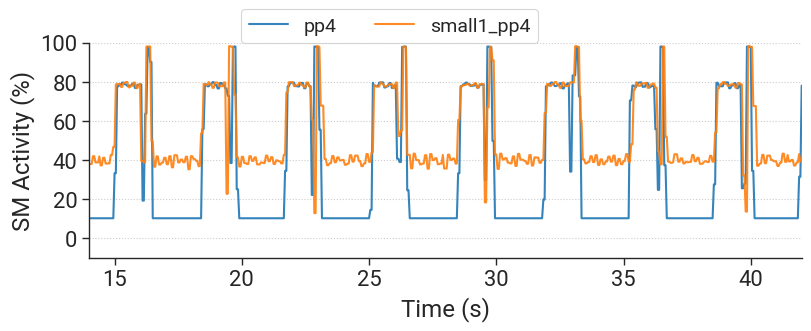

In [18]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_pp4_gpu0_util_v2.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_small1_pp4_gpu0_util_v2.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values*50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values-364)*50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
# pp4_smact = np.where(pp4_smact > 90, 82, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
# small1_pp4_smact = np.where(small1_pp4_smact > 90, 82, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(14, 42)
# ax1.set_xticks(np.arange(30,80,3))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('Resnet18, bs=512, scale=8')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.2), fontsize=14, frameon=True)
save = False
if save:
    fig.savefig(f"./figures/util_trace.pdf", bbox_inches="tight")

# RevGAT small1 then pp4

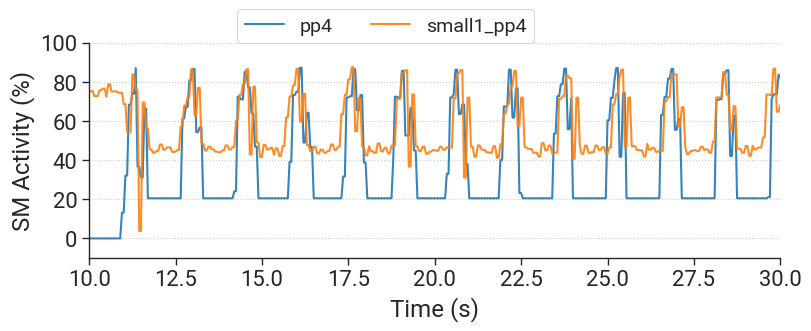

In [101]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_pp4_gpu0_util_v2.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_small1_pp4_gpu0_util_v2.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values[:] * 50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values[:] - 401) * 50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
pp4_smact = np.where(pp4_smact > 90, 80, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
small1_pp4_smact = np.where(small1_pp4_smact > 90, 80, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(10, 30)
# ax1.set_xticks(np.arange(20,40,1))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('RevGAT')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.2), fontsize=14, frameon=True)
save = False
if save:
    fig.savefig(f"./figures/util_trace.pdf", bbox_inches="tight")

# RevGAT small4 then pp4

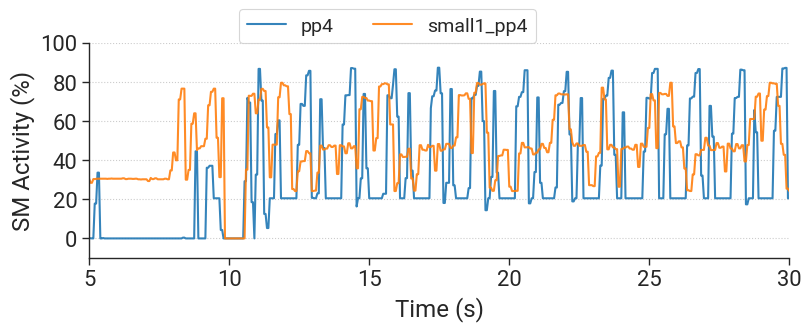

In [ ]:
import warnings
warnings.filterwarnings("ignore")
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_pp4_gpu1_util.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_small4_pp4_gpu1_util.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values[:] * 50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values[:]-311) * 50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
pp4_smact = np.where(pp4_smact > 90, 80, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
small1_pp4_smact = np.where(small1_pp4_smact > 90, 80, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=1.5, color=cmp[0], alpha=0.9)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=1.5, color=cmp[1], alpha=0.9)

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(5, 30)
# ax1.set_xticks(np.arange(20,40,1))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('RevGAT')
sns.despine()
ax1.legend(loc=2, 
           ncol=3,
           bbox_to_anchor=(0.2, 1.2), fontsize=14, frameon=True)

save = False
if save:
    fig.savefig(f"{SAVEPATH}/util_trace.pdf", bbox_inches="tight")

# GPU0 final result

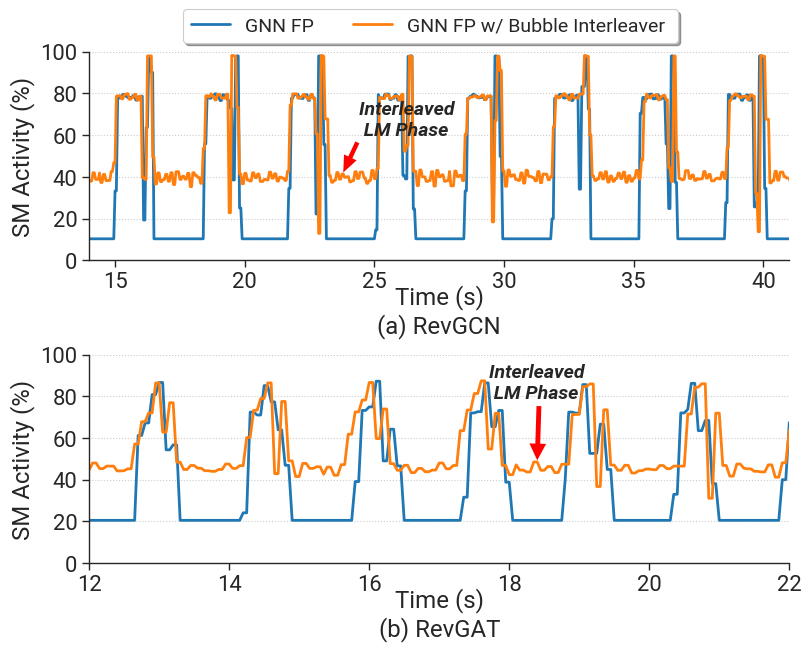

In [23]:
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, figsize=(8, 6.4))

# -------------------------------------- fig 1 -------------------------------------- 

df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_pp4_gpu0_util_v2.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_small1_pp4_gpu0_util_v2.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values*50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values-364)*50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
# pp4_smact = np.where(pp4_smact > 90, 82, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
# small1_pp4_smact = np.where(small1_pp4_smact > 90, 82, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='GNN FP', linewidth=2, color=cmp[0], alpha=1)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='GNN FP w/ Bubble Interleaver ', linewidth=2, color=cmp[1], alpha=1)

ax1.annotate("Interleaved \n LM Phase", xy=(23.8, 42.1), xytext = (24.4, 60), fontweight='bold',fontstyle='italic', arrowprops=dict(facecolor='red', edgecolor="none", width=3.2, headwidth=10, shrink=0), fontsize=14)

ax1.set_xlabel(f"Time (s)\n(a) RevGCN", multialignment='center', labelpad=-6)
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(0, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(14, 41)
ax1.set_xticks(np.arange(15,41,5))
ax1.grid(axis="y", linestyle=":")
# ax1.set_title('Resnet18, bs=512, scale=8')
sns.despine()
ax1.legend(loc=2, 
            ncol=3,
            bbox_to_anchor=(0.12, 1.25), 
            frameon=True,
            fancybox=True,
            shadow=True,
            fontsize=14,
           )

# -------------------------------------- fig 2 -------------------------------------- 

df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_pp4_gpu0_util_v2.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgat/revgat_small1_pp4_gpu0_util_v2.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values[:] * 50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values[:] - 401) * 50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
pp4_smact = np.where(pp4_smact > 90, 80, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
small1_pp4_smact = np.where(small1_pp4_smact > 90, 80, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

x_small1_pp4_highlight = x_small1_pp4[761:779]

ax2.plot(x_pp4, pp4_smact, label='pp4', linewidth=2, color=cmp[0], alpha=1)
ax2.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=2, color=cmp[1], alpha=1)

# ax2.fill_between(x_small1_pp4_highlight, small1_pp4_smact[761:779]+3, small1_pp4_smact[761:779]-3, facecolor=cmp[1], alpha=0.2)
ax2.annotate("Interleaved \n LM Phase", xy=(18.4, 49), xytext = (17.71, 79), fontweight='bold',fontstyle='italic', arrowprops=dict(facecolor='red', edgecolor="none", width=3.5, headwidth=12, shrink=0.01), fontsize=14)

ax2.set_xlabel(f"Time (s)\n(b) RevGAT", multialignment='center', labelpad=-6)
ax2.set_ylabel(f"SM Activity (%)")
ax2.set_ylim(0, 100)
y_ticks = np.arange(0, 120, 20)
ax2.set_yticks(y_ticks)
ax2.set_xlim(12, 22)
ax2.set_xticks(np.arange(12,23,2))
ax2.grid(axis="y", linestyle=":")
# ax1.set_title('RevGAT')

save = True
if save:
    fig.savefig(f"{SAVEPATH}/smact1.pdf", bbox_inches="tight")


# RevGCN small1 on GPU1, GPU2, GPU3 

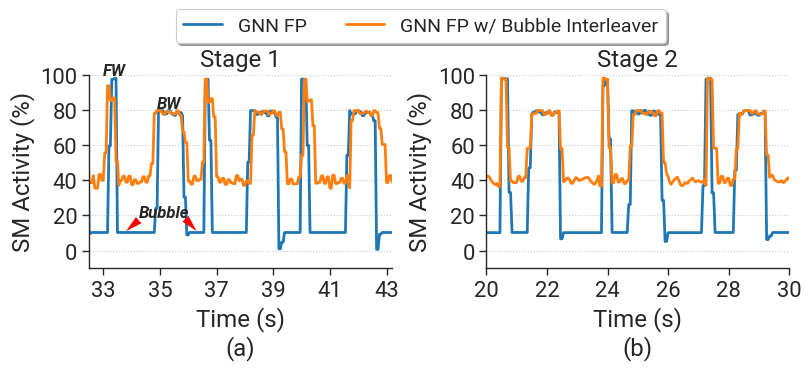

In [24]:
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

#### Fig 1 ####
# Figure 1
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_pp4_gpu1_util.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_small1_pp4_gpu1_util.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values*50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values-127)*50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
# pp4_smact = np.where(pp4_smact > 90, 82, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
# small1_pp4_smact = np.where(small1_pp4_smact > 90, 82, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

ax1.plot(x_pp4, pp4_smact, label='pp4', linewidth=2, color=cmp[0], alpha=1)
ax1.plot(x_small1_pp4, small1_pp4_smact, label='small1_pp4', linewidth=2, color=cmp[1], alpha=1)

ax1.set_xlabel(f"Time (s)\n(a)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax1.set_yticks(y_ticks)
ax1.set_xlim(32.5, 43.2)

ax1.set_xticks(np.arange(33, 44, 2))
ax1.grid(axis="y", linestyle=":")
ax1.set_title('Stage 1')

#### Fig 2 ####
df_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_pp4_gpu2_util.csv')
df_small1_pp4_gpu0 = pd.read_csv('./dcgmi_logs/revgcn/revgcn_small1_pp4_gpu2_util.csv')
# df_rayes = pd.read_csv('./dcgmi_logs/rs18_rayes_util.csv')

x_pp4 = df_pp4_gpu0.index.values *50/1000
x_small1_pp4 = (df_small1_pp4_gpu0.index.values - 639) *50/1000

pp4_smact = df_pp4_gpu0['SMACT'][:]*100
# pp4_smact = np.where(pp4_smact > 90, 82, pp4_smact)
# pp4_smact = np.where(pp4_smact < 30, 40, pp4_smact)
pp4_smocc = df_pp4_gpu0['SMOCC']*100
pp4_gputil = df_pp4_gpu0['GPUTL']

small1_pp4_smact = df_small1_pp4_gpu0['SMACT'][:]*100
# small1_pp4_smact = np.where(small1_pp4_smact > 90, 82, small1_pp4_smact)
# small1_pp4_smact = np.where(small1_pp4_smact < 30, 40, small1_pp4_smact)

# Generate mask for values less than 30
mask = small1_pp4_smact < 30

# Generate random values with mean 40 and standard deviation 3
from scipy.ndimage import gaussian_filter1d
random_values = np.random.normal(40, 2, size=np.sum(mask))
random_values = gaussian_filter1d(random_values, sigma=0.8)

# Apply the random values where the mask is True
small1_pp4_smact[mask] = random_values

A, = ax2.plot(x_pp4, pp4_smact, label='GNN FP', linewidth=2, color=cmp[0], alpha=1)
B, = ax2.plot(x_small1_pp4, small1_pp4_smact, label='GNN FP w/ Bubble Interleaver', linewidth=2, color=cmp[1], alpha=1)

ax2.set_xlabel(f"Time (s)\n(b)")
ax2.set_ylabel(f"SM Activity (%)")
ax2.set_ylim(-10, 100)
y_ticks = np.arange(0, 120, 20)
ax2.set_yticks(y_ticks)
ax2.set_xlim(20, 30)

ax2.set_xticks(np.arange(20,31,2))
ax2.grid(axis="y", linestyle=":")
ax2.set_title('Stage 2')


ax1.annotate("FW", xy=(33, 100), xytext = (33, 100), fontweight='bold',fontstyle='italic', 
            #  arrowprops=dict(facecolor='red', edgecolor="none", width=3.5, headwidth=12, shrink=0.01), 
             fontsize=12)
ax1.annotate("BW", xy=(35, 80), xytext = (34.9, 81), fontweight='bold',fontstyle='italic', 
            #  arrowprops=dict(facecolor='red', edgecolor="none", width=3.5, headwidth=12, shrink=0.01), 
             fontsize=12)
ax1.annotate("Bubble", xy=(33.8, 11), xytext = (34.25, 19), fontweight='bold',fontstyle='italic', 
             arrowprops=dict(facecolor='red', edgecolor="none", width=3, headwidth=6, shrink=0.01), 
             fontsize=12)
ax1.annotate(" ", xy=(36.3, 11), xytext = (35.8, 19), fontweight='bold',fontstyle='italic', 
             arrowprops=dict(facecolor='red', edgecolor="none", width=3, headwidth=6, shrink=0.01), 
             fontsize=12)


sns.despine()
# A = mpatches.Patch(color=cmp[0], alpha=0.9, label="GNN FP")
# B = mpatches.Patch(facecolor=cmp[1], alpha=0.9, label="GNN FP w/ Bubble Interleaver ")
# B = mpatches.Patch(facecolor=cmp[1], alpha=0.8, edgecolor="black", label="FlashAttn FW")
fig.legend(loc=2, 
           ncol=3,
           handles=[A, B],
           bbox_to_anchor=(0.2, 1.14), fontsize=14, 
            frameon=True,
            fancybox=True,
            shadow=True,
           )


save=True
if save:
    fig.savefig(f"{SAVEPATH}/smact_stage1_2.pdf", bbox_inches="tight")